## Logistic Regression — End-to-End Workflow

We’ll build a full supervised classification pipeline with Logistic Regression:
	•	Data Exploration: load, inspect, visualize
	•	Preprocessing: stratified split, feature scaling (important for LR + regularization)
	•	Modeling: from-scratch binary logistic (gradient descent) and scikit-learn LogisticRegression, with tuning
	•	Evaluation: accuracy, precision/recall/F1, ROC-AUC, ROC/PR curves, confusion matrix, coefficients & odds ratios

Concept: Logistic Regression models
$$P(y=1\mid x)=\sigma(\beta_0+\beta^\top x),\quad \sigma(z)=\frac{1}{1+e^{-z}}$$
and chooses \beta to maximize likelihood (or minimize log-loss), often with L2/L1 regularization.

## Setup

In [21]:
# Imports & reproducibility
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from typing import Optional, Tuple, Union, Dict
from IPython.display import display

# sklearn utilities
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
    roc_auc_score,
    roc_curve,
    average_precision_score,
    precision_recall_curve,
)

# Optional viz
try:
    import seaborn as sns
except Exception:
    sns = None

np.random.seed(42)
plt.rcParams["figure.figsize"] = (6.8, 4.2)
plt.rcParams["axes.grid"] = True

## Data Exploration

We’ll use the Breast Cancer Wisconsin dataset (binary: malignant vs benign).
We’ll inspect shape, basic stats, class balance, and correlations.

Shape: (569, 31)


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,...,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946,0.627417
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,...,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061,0.483918
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040,0.000000
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460,0.000000
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040,1.000000
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080,1.000000
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500,1.000000



Class counts (0=malignant, 1=benign):


target
1    357
0    212
Name: count, dtype: int64

,corr_with_target
target,1.000000
smoothness error,0.067016
mean fractal dimension,0.012838
texture error,0.008303
symmetry error,0.006522
fractal dimension error,-0.077972
concavity error,-0.253730
compactness error,-0.292999
worst fractal dimension,-0.323872
mean symmetry,-0.330499


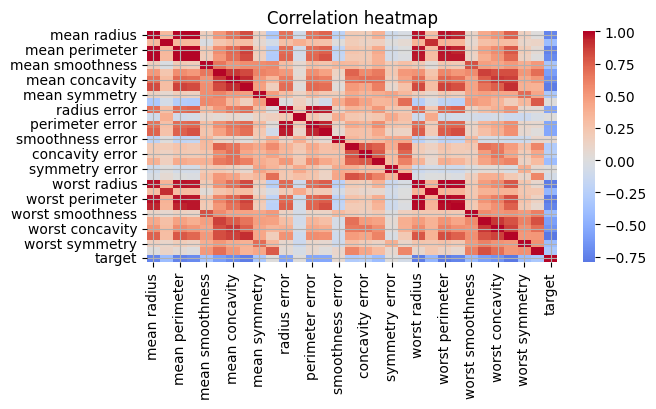

In [22]:
# Load dataset
cancer = load_breast_cancer(as_frame=True)
X: pd.DataFrame = cancer.data.copy()
y: pd.Series = pd.Series(cancer.target, name="target")  # 0=malignant, 1=benign

df = X.copy()
df["target"] = y

print("Shape:", df.shape)
display(df.head())
display(df.describe())

print("\nClass counts (0=malignant, 1=benign):")
display(y.value_counts())

# Correlations with target
corr_target = df.corr(numeric_only=True)["target"].sort_values(ascending=False)
display(corr_target.to_frame("corr_with_target").head(10))

# Optional: full heatmap (dense)
if sns is not None:
    try:
        sns.heatmap(df.corr(numeric_only=True), cmap="coolwarm", center=0)
        plt.title("Correlation heatmap")
        plt.tight_layout(); plt.show()
    except Exception as e:
        print("Skipping heatmap:", e)
else:
    print("Seaborn not installed; skipping heatmap.")

## Preprocessing
	•	Stratified train/test split (preserve class balance)
	•	Standardize features (recommended for Logistic Regression + penalties)

In [23]:
# Train/Test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)
print("Train:", X_train.shape, " Test:", X_test.shape)
print("Train class balance:\n", y_train.value_counts(normalize=True))

Train: (426, 30)  Test: (143, 30)
Train class balance:
 target
1    0.626761
0    0.373239
Name: proportion, dtype: float64


## Modeling

We’ll train:
	1.	From-scratch binary logistic regression via gradient descent (with optional L2 penalty)
	2.	scikit-learn LogisticRegression in a pipeline with scaling
We’ll also do a small GridSearchCV over C (inverse regularization), penalty, and solver.

In [24]:
class SimpleLogisticRegression:
    """
    Minimal binary Logistic Regression with L2 regularization (no intercept penalty).
    Optimized via batch gradient descent with early stopping.
    For educational purposes (not as fast/robust as sklearn).
    """
    def __init__(
        self,
        lr: float = 0.1,
        max_iter: int = 5000,
        l2: float = 0.0,
        tol: float = 1e-6,
        verbose: bool = False,
        fit_intercept: bool = True
    ):
        self.lr = float(lr)
        self.max_iter = int(max_iter)
        self.l2 = float(l2)
        self.tol = float(tol)
        self.verbose = bool(verbose)
        self.fit_intercept = bool(fit_intercept)

        self.coef_: Optional[np.ndarray] = None  # (d,)
        self.intercept_: float = 0.0
        self.loss_curve_: list[float] = []

    @staticmethod
    def _sigmoid(z: np.ndarray) -> np.ndarray:
        # stable sigmoid
        z_clip = np.clip(z, -500, 500)
        return 1.0 / (1.0 + np.exp(-z_clip))

    def _add_intercept(self, X: np.ndarray) -> np.ndarray:
        if not self.fit_intercept:
            return X
        n = X.shape[0]
        return np.hstack([np.ones((n, 1)), X])

    def fit(self, X: Union[pd.DataFrame, np.ndarray], y: Union[pd.Series, np.ndarray]):
        X = np.asarray(X, dtype=float)
        y = np.asarray(y, dtype=float).reshape(-1, 1)
        n, d = X.shape

        X_aug = self._add_intercept(X)
        d_aug = X_aug.shape[1]

        w = np.zeros((d_aug, 1))  # includes intercept if enabled

        def loss_and_grad(w_vec: np.ndarray):
            z = X_aug @ w_vec
            p = self._sigmoid(z)
            # log-loss (avoid log(0))
            eps = 1e-12
            loss = -(y * np.log(p + eps) + (1 - y) * np.log(1 - p + eps)).mean()
            # L2 (no penalty for intercept term)
            if self.l2 > 0:
                w_pen = w_vec.copy()
                if self.fit_intercept:
                    w_pen[0] = 0.0
                loss += 0.5 * self.l2 * float((w_pen.T @ w_pen) / n)
            # gradient
            grad = (X_aug.T @ (p - y)) / n
            if self.l2 > 0:
                w_pen = w_vec.copy()
                if self.fit_intercept:
                    w_pen[0] = 0.0
                grad += (self.l2 / n) * w_pen
            return float(loss), grad

        prev_loss = np.inf
        for it in range(self.max_iter):
            loss, grad = loss_and_grad(w)
            self.loss_curve_.append(loss)

            w -= self.lr * grad

            if abs(prev_loss - loss) < self.tol:
                if self.verbose:
                    print(f"Early stop at iter {it}, loss={loss:.6f}")
                break
            prev_loss = loss
            if self.verbose and (it % 500 == 0):
                print(f"iter={it:5d}  loss={loss:.6f}")

        # unpack parameters
        if self.fit_intercept:
            self.intercept_ = float(w[0])
            self.coef_ = w[1:, 0].copy()
        else:
            self.intercept_ = 0.0
            self.coef_ = w[:, 0].copy()

        return self

    def decision_function(self, X: Union[pd.DataFrame, np.ndarray]) -> np.ndarray:
        X = np.asarray(X, dtype=float)
        z = X @ self.coef_ + self.intercept_
        return z

    def predict_proba(self, X: Union[pd.DataFrame, np.ndarray]) -> np.ndarray:
        z = self.decision_function(X)
        p1 = self._sigmoid(z)
        # return [P(class0), P(class1)]
        return np.vstack([1 - p1, p1]).T

    def predict(self, X: Union[pd.DataFrame, np.ndarray]) -> np.ndarray:
        p = self.predict_proba(X)[:, 1]
        return (p >= 0.5).astype(int)

In [25]:
# Build models
# 1) From-scratch path: scale features manually then fit SimpleLogisticRegression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

logreg_scratch = SimpleLogisticRegression(lr=0.1, max_iter=5000, l2=0.1, tol=1e-7, verbose=False)
logreg_scratch.fit(X_train_scaled, y_train)

# 2) sklearn LogisticRegression in a Pipeline
logreg_sk = Pipeline([
    ("scaler", StandardScaler()),
    ("lr", LogisticRegression(
        penalty="l2", solver="liblinear", C=1.0, max_iter=5000, random_state=42
    ))
])
logreg_sk.fit(X_train, y_train)

,steps,"[('scaler', ...), ('lr', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0


## Hyperparameter Tuning

We’ll tune C (inverse regularization), penalty, and solver.
	•	For L1, use liblinear or saga
	•	For L2, lbfgs/liblinear/saga are fine on binary

In [26]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

param_grid = {
    "lr__penalty": ["l2", "l1"],
    "lr__solver": ["liblinear"],     # keep simple; add "saga" if desired
    "lr__C": [0.01, 0.1, 1.0, 3.0, 10.0],
    "lr__max_iter": [5000]
}

grid = GridSearchCV(
    estimator=Pipeline([
        ("scaler", StandardScaler()),
        ("lr", LogisticRegression(random_state=42))
    ]),
    param_grid=param_grid,
    scoring="roc_auc",
    cv=cv,
    n_jobs=-1
)

grid.fit(X_train, y_train)
print("Best params:", grid.best_params_)
print("Best CV ROC-AUC:", grid.best_score_)
logreg_best = grid.best_estimator_

Best params: {'lr__C': 1.0, 'lr__max_iter': 5000, 'lr__penalty': 'l2', 'lr__solver': 'liblinear'}
Best CV ROC-AUC: 0.9961506165325398


## Evaluation

We’ll compute accuracy, precision, recall, F1, ROC-AUC; plot ROC and Precision-Recall curves; show confusion matrix and coefficients/odds ratios.

In [27]:
def evaluate_binary(name: str, model, X_te, y_te):
    # predictions & probabilities
    y_pred = model.predict(X_te)
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_te)[:, 1]
    else:
        # fall back to decision_function -> min-max to [0,1] (rarely needed)
        z = model.decision_function(X_te)
        y_proba = (z - z.min()) / (z.max() - z.min() + 1e-12)

    acc = accuracy_score(y_te, y_pred)
    prec = precision_score(y_te, y_pred, zero_division=0)
    rec = recall_score(y_te, y_pred, zero_division=0)
    f1 = f1_score(y_te, y_pred, zero_division=0)
    auc = roc_auc_score(y_te, y_proba)
    ap = average_precision_score(y_te, y_proba)  # area under PR curve

    print(f"\n=== {name} ===")
    print(f"Accuracy: {acc:.4f} | Precision: {prec:.4f} | Recall: {rec:.4f} | F1: {f1:.4f}")
    print(f"ROC-AUC: {auc:.4f} | Average Precision (PR-AUC): {ap:.4f}")
    print("Confusion matrix:\n", confusion_matrix(y_te, y_pred))
    print("Classification report:\n", classification_report(y_te, y_pred, target_names=cancer.target_names))
    return {"accuracy": acc, "precision": prec, "recall": rec, "f1": f1, "roc_auc": auc, "ap": ap}

metrics = {}
metrics["LogReg (scratch)"] = evaluate_binary("LogReg (scratch)", logreg_scratch, X_test_scaled, y_test)
metrics["LogReg (sklearn)"] = evaluate_binary("LogReg (sklearn)", logreg_sk, X_test, y_test)
metrics["LogReg (tuned)"] = evaluate_binary("LogReg (tuned)", logreg_best, X_test, y_test)

display(pd.DataFrame(metrics).T)


=== LogReg (scratch) ===
Accuracy: 0.9860 | Precision: 0.9889 | Recall: 0.9889 | F1: 0.9889
ROC-AUC: 0.9973 | Average Precision (PR-AUC): 0.9983
Confusion matrix:
 [[52  1]
 [ 1 89]]
Classification report:
               precision    recall  f1-score   support

   malignant       0.98      0.98      0.98        53
      benign       0.99      0.99      0.99        90

    accuracy                           0.99       143
   macro avg       0.99      0.99      0.99       143
weighted avg       0.99      0.99      0.99       143


=== LogReg (sklearn) ===
Accuracy: 0.9860 | Precision: 0.9889 | Recall: 0.9889 | F1: 0.9889
ROC-AUC: 0.9977 | Average Precision (PR-AUC): 0.9986
Confusion matrix:
 [[52  1]
 [ 1 89]]
Classification report:
               precision    recall  f1-score   support

   malignant       0.98      0.98      0.98        53
      benign       0.99      0.99      0.99        90

    accuracy                           0.99       143
   macro avg       0.99      0.99      

,accuracy,precision,recall,f1,roc_auc,ap
LogReg (scratch),0.986014,0.988889,0.988889,0.988889,0.997275,0.998297
LogReg (sklearn),0.986014,0.988889,0.988889,0.988889,0.997694,0.998577
LogReg (tuned),0.986014,0.988889,0.988889,0.988889,0.997694,0.998577


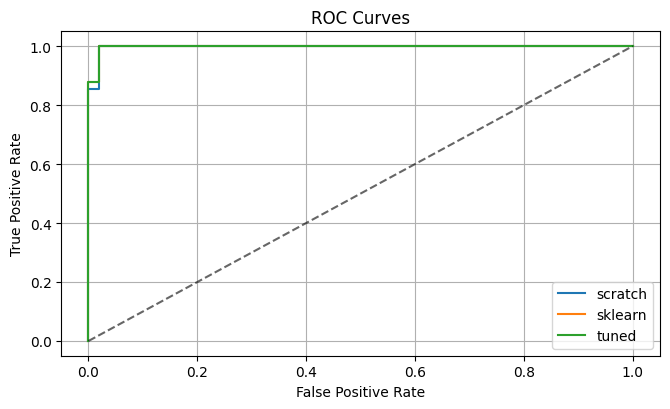

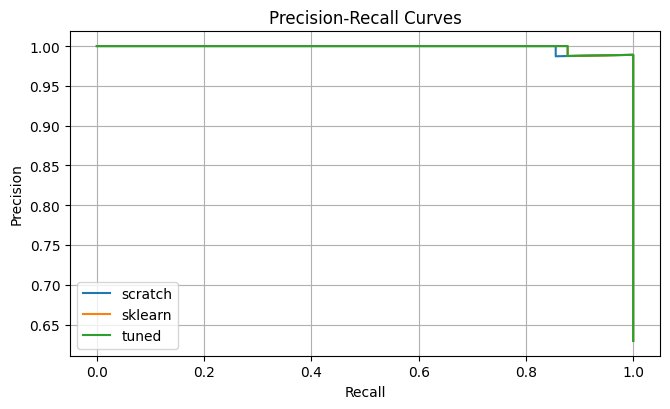

In [28]:
# ROC & PR curves
plt.figure()
for name, model, X_te in [
    ("scratch", logreg_scratch, X_test_scaled),
    ("sklearn", logreg_sk, X_test),
    ("tuned", logreg_best, X_test),
]:
    y_proba = model.predict_proba(X_te)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label=name)
plt.plot([0,1], [0,1], "k--", alpha=0.6)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend()
plt.tight_layout(); plt.show()

plt.figure()
for name, model, X_te in [
    ("scratch", logreg_scratch, X_test_scaled),
    ("sklearn", logreg_sk, X_test),
    ("tuned", logreg_best, X_test),
]:
    y_proba = model.predict_proba(X_te)[:, 1]
    prec, rec, _ = precision_recall_curve(y_test, y_proba)
    plt.plot(rec, prec, label=name)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves")
plt.legend()
plt.tight_layout(); plt.show()

In [29]:
# Coefficients & odds ratios (from sklearn models)
def coef_table(model, step_name: str, feature_names):
    inner = model.named_steps[step_name]
    coefs = inner.coef_.ravel()
    odds = np.exp(coefs)  # odds ratios
    tab = pd.DataFrame({
        "feature": feature_names,
        "coef": coefs,
        "odds_ratio": odds
    }).sort_values("coef", ascending=False)
    return tab

print("\nCoefficients (sklearn base):")
display(coef_table(logreg_sk, "lr", list(X.columns)).head(12))

print("\nCoefficients (tuned):")
display(coef_table(logreg_best, "lr", list(X.columns)).head(12))


Coefficients (sklearn base):


,feature,coef,odds_ratio
5,mean compactness,0.714430,2.043023
15,compactness error,0.613524,1.846928
18,symmetry error,0.420640,1.522935
19,fractal dimension error,0.358734,1.431516
11,texture error,0.262415,1.300066
16,concavity error,0.175452,1.191784
9,mean fractal dimension,0.061787,1.063736
25,worst compactness,0.037308,1.038013
8,mean symmetry,-0.138874,0.870338
14,smoothness error,-0.150291,0.860458



Coefficients (tuned):


,feature,coef,odds_ratio
5,mean compactness,0.714430,2.043023
15,compactness error,0.613524,1.846928
18,symmetry error,0.420640,1.522935
19,fractal dimension error,0.358734,1.431516
11,texture error,0.262415,1.300066
16,concavity error,0.175452,1.191784
9,mean fractal dimension,0.061787,1.063736
25,worst compactness,0.037308,1.038013
8,mean symmetry,-0.138874,0.870338
14,smoothness error,-0.150291,0.860458


Key Takeaways
	•	Logistic Regression models P(y=1|x) with a sigmoid of a linear score; trained by minimizing log-loss.
	•	Regularization matters:
	•	L2 (ridge) shrinks coefficients (helps with collinearity).
	•	L1 (lasso) induces sparsity (feature selection).
	•	Control strength with C (inverse of regularization); smaller C ⇒ stronger regularization.
	•	Scaling features is recommended, especially with penalties and different solvers.
	•	Metrics: don’t rely on accuracy alone—include precision, recall, F1, ROC-AUC, PR-AUC; inspect confusion matrix.
	•	Interpretability: coefficients map to odds ratios via $e^{\beta_j}$.